# Projet Deep Learning
# Génération automatique de commentaires d'images par Deep Learning

**Auteurs:** Farid GNANKAMBARY, Jean-Baptiste GREFFE<br>
**Date :** 17/01/2024<br>
**Description:** Réalisation d'un modèle de Deep Learning composé d'un CNN et d'un Transformer pour la génération automatique de commentaires descriptifs d'images<br>
**Tags :** NLP, Computer Vision, Transformers

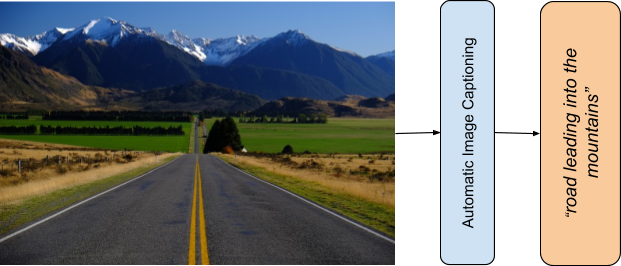

Le domaine de l'Automatic Image Captioning constitue une branche passionnante du Deep Learning où l'objectif est d'apprendre à un modèle à générer des descriptions textuelles précises et pertinentes pour des images données. Ce domaine fusionne la vision par ordinateur et le traitement du langage naturel, offrant ainsi des solutions novatrices pour la compréhension et l'interprétation d'images par des systèmes informatiques. <br>

L'Automatic Image Captioning repose généralement sur des réseaux de neurones profonds, tels que les réseaux neuronaux récurrents (RNN) ou les transformers, qui apprennent à établir des correspondances entre les caractéristiques visuelles extraites des images et le langage naturel. Ces modèles sont formés sur de vastes ensembles de données annotées, où chaque image est associée à une ou plusieurs descriptions humaines. <br><br>

Les applications de ce domaine sont très variées :

*Accessibilité visuelle* : Les systèmes de légendage automatique peuvent améliorer l'accessibilité pour les personnes malvoyantes ou non voyantes en fournissant des descriptions textuelles détaillées des images.

*Indexation de contenu multimédia* : Les moteurs de recherche et les bibliothèques multimédias peuvent utiliser le légendage automatique pour indexer et rechercher des images en fonction de leur contenu, facilitant ainsi la gestion et la recherche d'informations visuelles.

*Assistance à la rédaction de contenu* : Les outils de création de contenu peuvent bénéficier du légendage automatique en suggérant des légendes ou des descriptions pour les images téléchargées, facilitant ainsi la création de contenu engageant.

*Robotique et autonomie* : Dans le domaine de la robotique, les robots équipés de capacités de compréhension visuelle améliorée peuvent utiliser le légendage automatique pour interagir de manière plus intelligente avec leur environnement. <br><br>


Les approches les plus avancées dans le domaine utilisent des réseaux de neurones profonds sophistiqués telles que les transformers, qui ont démontré une capacité exceptionnelle à capturer les relations complexes entre les éléments visuels et linguistiques. Des modèles comme BERT (Bidirectional Encoder Representations from Transformers) et ses variantes ont également été adaptés pour améliorer la qualité des légendes générées.

Des techniques d'attention, permettant au modèle de se concentrer sur des parties spécifiques de l'image lors de la génération de légendes, ont également joué un rôle crucial dans l'amélioration de la performance. L'utilisation de données massives, y compris des ensembles de données pré-entraînés sur de vastes corpus textuels, a permis d'obtenir des modèles plus généraux et robustes.

Malgré ces avancées, des défis subsistent, notamment la génération de légendes plus diversifiées, l'adaptation à des scénarios multimodaux et la compréhension fine du contexte. L'exploration continue de nouvelles architectures et de stratégies d'entraînement reste au cœur des recherches pour amener le légendage automatique d'images à des niveaux de performance encore plus élevés.

## Setup

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

## Dataset

Nous utiliserons pour ce travail le dataset **Flickr8K**.<br>

Ce dernier est composé d’environ 8000 images accompagnées de 5 commentaires descriptifs de ces dernières. Ceci nous permet notamment d'envisager notre tâche comme celle d'un apprentissage supervisé.


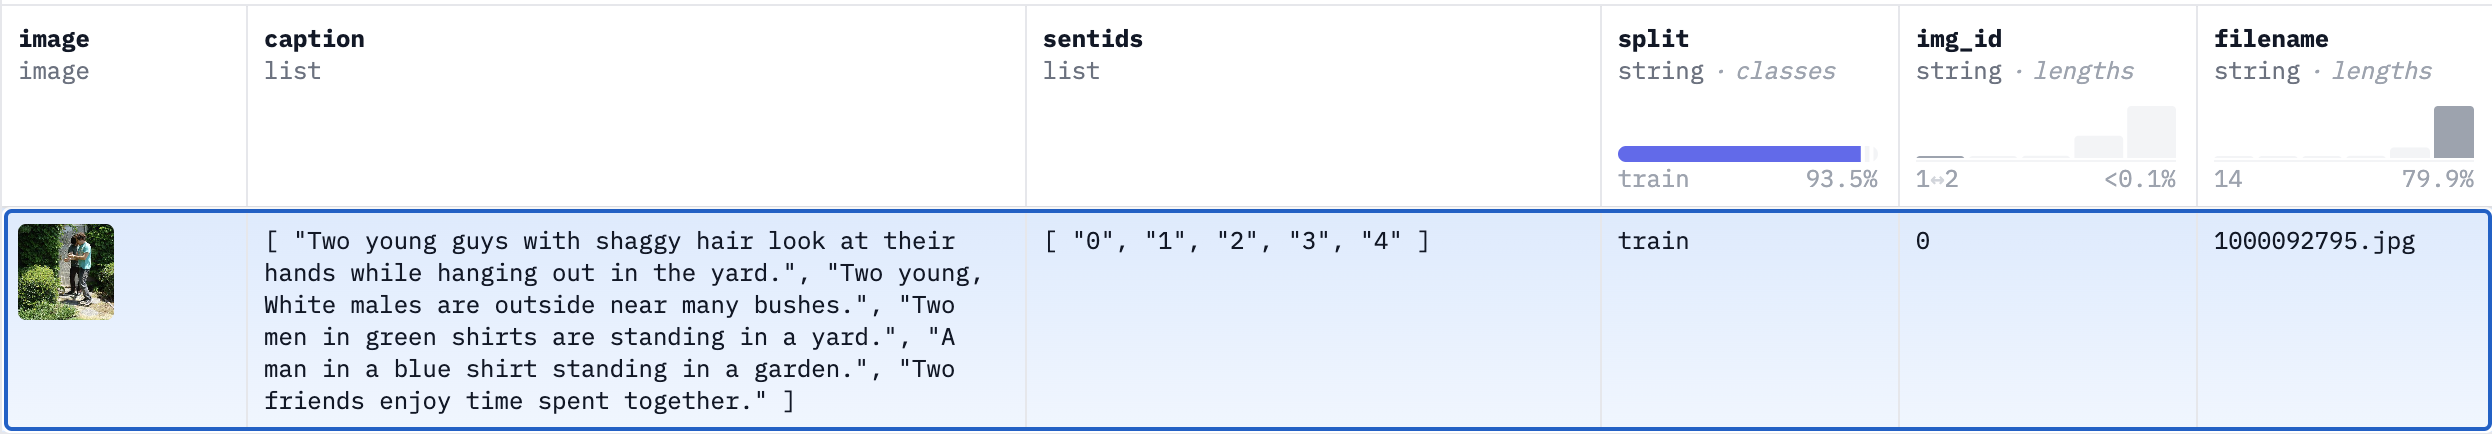






In [ ]:
# Nous téléchargeons le dataset depuis GitHub
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

Nous pouvons ensuite définir quelques hyperparamètres de notre problème, qui nous serons utiles pour la suite.

In [ ]:
# Chemin vers les images
IMAGES_PATH = "Flicker8k_Dataset"

# Dimensions des images
IMAGE_SIZE = (299, 299)

# Taille du vocabulaire
VOCAB_SIZE = 10000

# Longueur fixe des séquences
SEQ_LENGTH = 25

# Dimension des images embeddings er token embeddings
EMBED_DIM = 512

# Nombre d'unités par couche dans le réseau feed-forward network
FF_DIM = 512

# Hyperparamnètres d’entraînement
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

## Préparation du dataset

Dans cette section, nous définissions quelques fonctions qui nous serviront à préparer le traitement de notre dataset par notre modèle.

In [ ]:
def load_captions_data(filename):
    """Mapping des captions et de leurs images correspondantes.

    Args:
        filename: Chemin vers le fichier contenant les captions.

    Returns:
        caption_mapping: Dictionnaire reliant les noms des images et leurs captions correspondants
        text_data: Liste contenant tous les captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            img_name, caption = line.split("\t")

            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # Nos tokens sont constitués à partir des mots des captions séparés par un espace
            tokens = caption.strip().split()

            # Nous retirons les captions qui sont trop longs ou trop courts
            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # Nous ajoutons un token de début et de fin a chaque caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Séparation du dataset de captions en ensembles d’entraînement et de validation.

    Args:
        caption_data (dict): Dictionnaire contenant les captions et les images mappées
        train_size (float): Fraction du dataset a utiliser pour l'entrainement
        shuffle (bool): Shuffle le dataset ou pas avant le split

    Returns:
        Ensembles d'entrainement et de validation en deux dictionnaires séparés
    """

    # Recuperation des noms de toutes les images
    all_images = list(caption_data.keys())

    # Shuffle éventuel
    if shuffle:
        np.random.shuffle(all_images)

    # Split en training et validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Retournes les splits
    return training_data, validation_data


# Charge le dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split le dataset en training et validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


## Vectorisation des données textuelles


Nous procédons à présent à une vectorisation des données textuelles, c'est-à-dire en une transformation de nos séquences de caractères en séquences d'entiers où chaque entier représente l'index du mot correspondant dans le vocabulaire. <br>
Nous effectuons cette opération à l'aide d'une couche `TextVectorization` de Keras.<br>
La fonction `custom_standardization` effectue un pré-traitement du texte avant le passage dans la couche de vectorisation.

In [ ]:
def custom_standardization(input_string):
    """convertion en minuscules (lowercase) et suppression de certains caractères spécifiques

    Args:
        input_string (string): une chaine de caractère représentant les captions

    Returns:
        La chaîne de caractère pré-traité
    """
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation des données d'images
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


## Construction d'un pipeline pour l’entraînement

Nous avons ici pour objectif construire un pipeline qui générera des paires (image, captions) en utilisant des objets `tf.data.Dataset`.
Ce pipeline consistera en deux étapes :

1. Lecture des images depuis le disque
2. Tokenisation des 5 captions correspondant à l'image

In [ ]:

def decode_and_resize(img_path):
    """lit le contenu du fichier en argument, décode l'image au format JPEG, la redimensionne à une taille spécifiée et convertit finalement les valeurs des pixels de l'image en nombres flottants.

    Args:
        img_path: Chemin vers l'images.

    Returns:
        L'image au format spécifié
    """
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    """crée un objet TensorFlow Dataset
    Args:
        images(tenseur): tenseur représentant les informations de l'image
        captions(tenseur): tenseur représentant les informations des légendes
    Returns:
        Dataset tensorflow
    """
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Transmet la liste des images et la liste des légendes correspondantes
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


## Construction de notre modèle

De nombreuses approches permettent de réaliser la tâche de l'Image Captioning. Plusieurs modèles utilisent des réseaux de neurones convolutifs, des réseaux récurrents, des Transformers ou une combinaison de ces derniers. Toutefois, selon l'approche choisie, il existe des inconvénients et des limites à considérer : capture des dépendances à long terme, extraction de features pertinents, temps d'entraînement et performance des modèles... <br>

Pour notre travail, il s'est avéré que la combinaison CNN pré-entraîné + Transformer était la plus convenable. <br><br>

L’architecture de notre modèle se compose donc de 3 parties :


**1. Un réseau CNN :** utilisé pour l'extraction de features des images. Plus précisément, nous utiliserons le réseau de neurones pré-entrainé `EfficientNet`, dont nous modifierons la sortie pour l'adapter à notre situation <br>
**2. Un TransformerEncoder :** les features extraits sont ensuite passés à un Transfromer-based Encodeur qui générera de nouvelles représentations des inputs. Pour cet encodeur, nous utilisons une seule tête d'attention. <br>
**3. Un TransformerDecoder :** ce modèle prend en entrée les sorties de l'encodeur ainsi que les séquences de texte et des informations sur leurs positions, et apprend à générer les captions d'images. Ce dernier est composé de deux têtes d'attention.

Des couches de normalisation et de Dropout sont également utilisées pour assurer un meilleur apprentissage du modèle. <br>

Les avantages d'utiliser un tel modèle sont que EfficientNet permet une extraction de features avec des performances élevées, tout en assurant une bonne utilisation des ressources. En l'associant à un Transformer, il nous est possible de modéliser des relations séquentielles du texte sans perdre l'efficacité dans la capture des images features.


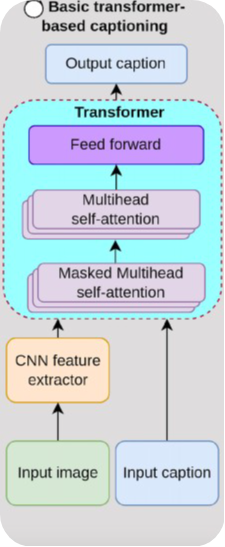

In [ ]:
# crée un modèle de réseau de neurones convolutifs (CNN) en utilisant l'architecture EfficientNetB0
def get_cnn_model():
    #crée une instance du modèle EfficientNetB0
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )

    # fige les poids du modèle EfficientNetB0
    base_model.trainable = False

    #récupère la sortie (output) du modèle EfficientNetB0. Cette sortie est la représentation apprise par le réseau pour les caractéristiques de l'image.
    base_model_out = base_model.output

    #Cette ligne ajoute une couche de redimensionnement (Reshape) pour transformer la sortie du modèle en une forme compatible avec les entrées d'autres parties du modèle
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)

    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        # initialisation des paramètres du bloc d'encodeur
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # initialisation des couches
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):

        # normalisation de l'entrée
        inputs = self.layernorm_1(inputs)

        # Transformation linéaire avec activation ReLU
        inputs = self.dense_1(inputs)

        # Application de l'attention multi-têtes à l'entrée
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )

        # Combinaison de l'attention avec l'entrée initiale, suivie d'une normalisation
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)

        # La couche d'embedding positionnelle se compose de deux sous-couches
        # Une couche d'embedding pour les tokens
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        #  Une couche d'embedding pour les positions
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )

        # Longueur maximale de la séquence
        self.sequence_length = sequence_length

        # Taille du vocabulaire, c'est-à-dire le nombre total de tokens uniques dans la séquence
        self.vocab_size = vocab_size

        # Dimension de l'espace d'embedding
        self.embed_dim = embed_dim

        # Échelle utilisée pour ajuster l'amplitude des embeddings
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        """renvoie la somme des embeddings des tokens et des embeddings positionnels
        Args:
            inputs: représente les indices des tokens dans la séquence
        Return:
          somme des embeddings des tokens et des embeddings positionnels
        """
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads

        # deux couches de MultiHeadAttention sont créées
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        # deux couches feedforward sont créées
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        # trois couches de normalisation sont créées
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        # couche d'embedding positionnelle
        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )

        # couche de sortie avec softmax
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Récupère les embeddings des images
        img_embed = self.cnn_model(batch_img)

        # 2. Passe chacune des 5 légendes une à une au decoder
        # avec les sorties de l'encodeur et calculer la perte ainsi que la précision
        # pour chaque image.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Met à jour le loss et l'accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Obtient la liste de tous les poids d'entrainement
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Obtient les gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Met à jour les poids d'entrainement
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Met à jour les trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Retourne les valeurs de loss et accuracy
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Récupère les embeddings des images
        img_embed = self.cnn_model(batch_img)

        # 2. Passe chacune des 5 légendes une à une au decoder
        # avec les sorties de l'encodeur et calculer la perte ainsi que la précision
        # pour chaque image.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Mise à jour de la perte et de la précision des batch
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Met à jour les trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Retourne les valeurs de perte et de précision
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # Nous devons lister nos métriques ici pour que la fonction `reset_states()` puisse être
        # appelé automatiquement.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
#Model summary

## Entraînement du modèle

Nous définissons à présent les paramètres d’entraînement de notre modèle `ImageCaptionModel` : <br>


1.   Loss function : *Sparse_Categorical_Cross_Entropy*
2.   *Early stopping*
3.   Un scheduler pour le learning_rate

Le modèle est compilé à l'aide de l'optimisateur *Adam*


Nous construisons également les courbes d'apprentissage de notre modèle afin de détecter d’éventuels problèmes (overfitting, underfitting...)

Epoch 1/30
96/96 [==============================] - 120s 962ms/step - loss: 28.0878 - acc: 0.1311 - val_loss: 20.4227 - val_acc: 0.3113
Epoch 2/30
96/96 [==============================] - 73s 762ms/step - loss: 19.3226 - acc: 0.3207 - val_loss: 17.9287 - val_acc: 0.3548
Epoch 3/30
96/96 [==============================] - 72s 751ms/step - loss: 17.4336 - acc: 0.3552 - val_loss: 16.8773 - val_acc: 0.3699
Epoch 4/30
96/96 [==============================] - 72s 747ms/step - loss: 16.3173 - acc: 0.3747 - val_loss: 16.2083 - val_acc: 0.3821
Epoch 5/30
96/96 [==============================] - 72s 750ms/step - loss: 15.5218 - acc: 0.3893 - val_loss: 15.7823 - val_acc: 0.3919
Epoch 6/30
96/96 [==============================] - 72s 750ms/step - loss: 14.8430 - acc: 0.4017 - val_loss: 15.4571 - val_acc: 0.3974
Epoch 7/30
96/96 [==============================] - 71s 737ms/step - loss: 14.3123 - acc: 0.4140 - val_loss: 15.2627 - val_acc: 0.4025
Epoch 8/30
96/96 [==============================] - 71

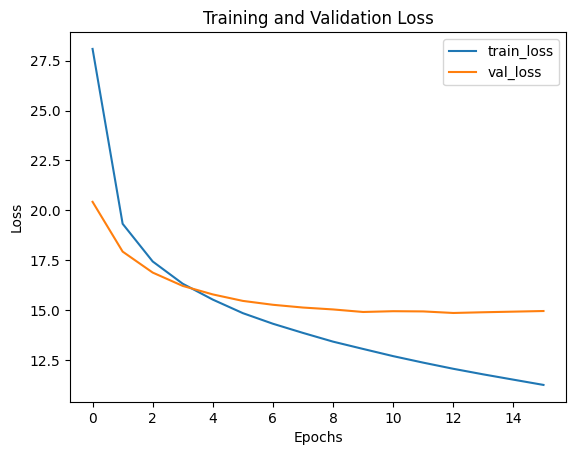

In [ ]:
# Definition de la fonction de perte
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='none',
)

# Critère d'EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler pour l'optimiseur
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Crée un learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compilation du modèle
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)


history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

# Plot training history
def plot_learning_curves(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Appel de la fonction pour tracer les courbes d'apprentissage
plot_learning_curves(history)

L'entraînement s'arrête grâce au critère d'early_stopping avant un overfitting

## Test sur quelques exemples

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Sélection d'une image aléatoirement du dataset de validation
    sample_img = np.random.choice(valid_images)

    # Lecture de l'image à partir du disque
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Transmission de l'image au CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Transmission des classes de l'image au Transformer Encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Génération de légende en utilisant le Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)

Nous pouvons à présent vérifier que notre modèle fonctionne correctement. <br>
La fonction `generate_caption()` choisit une image à tester aléatoirement, et produit grâce à notre modèle la caption correspondante.

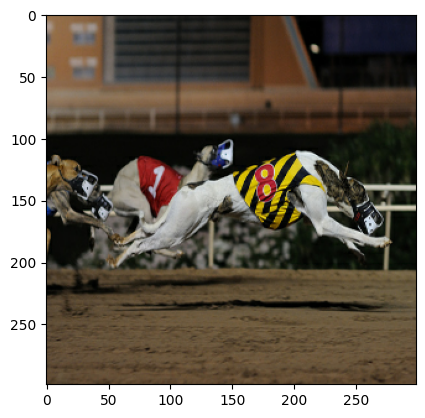

Predicted Caption:  a greyhound with a number 8 is racing


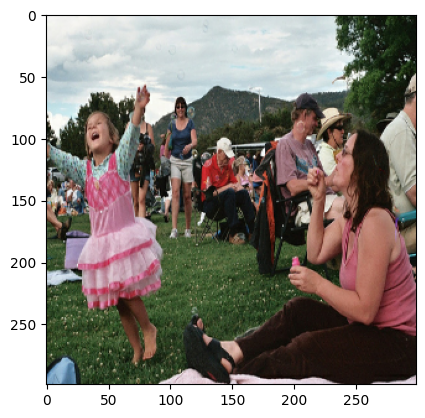

Predicted Caption:  a woman in a pink dress and pink dress are standing in front of a group of people


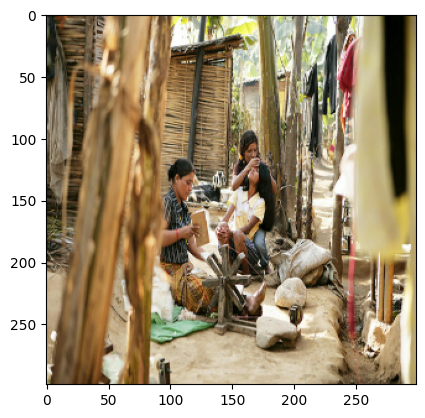

Predicted Caption:  a man and a woman sit on a bench


In [ ]:
# Vérification des prédictions pour un petit échantillon
generate_caption()
generate_caption()
generate_caption()

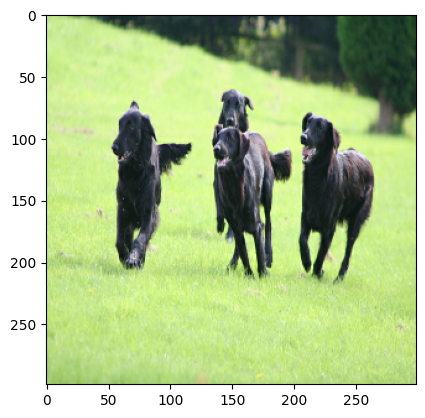

Predicted Caption:  two black dogs running through a field


In [ ]:
generate_caption()

## Conclusion

Nous avons constaté que le modèle commence à générer des commentaires vraisemblables et compréhensibles après quelques epochs. Notons cependant que du fait de notre limitation en ressources (temps, GPU, connaissances), nous l'avons entraîné avec quelques contraintes, comme un nombre minimal de têtes d'attention. <br>
Pour améliorer les prédictions, il pourrait être judicieux de modifier les paramètres d’entraînement, voire l’architecture de notre modèle.